# Everglades heron rookeries and NEXRAD radar data exploration

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tempfile
import pytz
from datetime import datetime
import pyart
import nexradaws
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
from scipy.spatial.distance import cdist 
from geopy.distance import distance as geodist 
from matplotlib import animation

templocation = tempfile.mkdtemp()

In [2]:
conn = nexradaws.NexradAwsInterface()

In [3]:
years = conn.get_avail_years()
print(years)

['1970', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']


There was a large colony event at Alley North () on April 1st, 2021 near the KAMX station in homestead florida

In [4]:
availscans = conn.get_avail_scans('2021', '04', '01', 'KAMX')
print("There are {} NEXRAD files available for April, 2021 for the KAMX radar.\n".format(len(availscans)))
print(availscans[0:4])

There are 314 NEXRAD files available for April, 2021 for the KAMX radar.

[<AwsNexradFile object - 2021/04/01/KAMX/KAMX20210401_000359_V06>, <AwsNexradFile object - 2021/04/01/KAMX/KAMX20210401_000845_V06>, <AwsNexradFile object - 2021/04/01/KAMX/KAMX20210401_001332_V06>, <AwsNexradFile object - 2021/04/01/KAMX/KAMX20210401_001819_V06>]


We want the scans around dawn, when the birds are likely to disperse from the colony

In [5]:
eastern_timezone = pytz.timezone('US/Eastern')
radar_id = 'KAMX'
start = eastern_timezone.localize(datetime(2021,4,2,4,0))
end = eastern_timezone.localize(datetime(2021,4,2,6,0))
scans = conn.get_avail_scans_in_range(start, end, radar_id)
print("There are {} scans available between {} and {}\n".format(len(scans), start, end))

There are 27 scans available between 2021-04-02 04:00:00-04:00 and 2021-04-02 06:00:00-04:00



In [6]:
scans = [scans[0], scans[5], scans[10], scans[15], scans[20], scans[25]]
results = conn.download(scans, templocation)

Downloaded KAMX20210402_095732_V06
Downloaded KAMX20210402_093343_V06
Downloaded KAMX20210402_080322_V06
Downloaded KAMX20210402_090957_V06
Downloaded KAMX20210402_085057_V06
Downloaded KAMX20210402_082711_V06
6 out of 6 files downloaded...0 errors


# Visualize scans

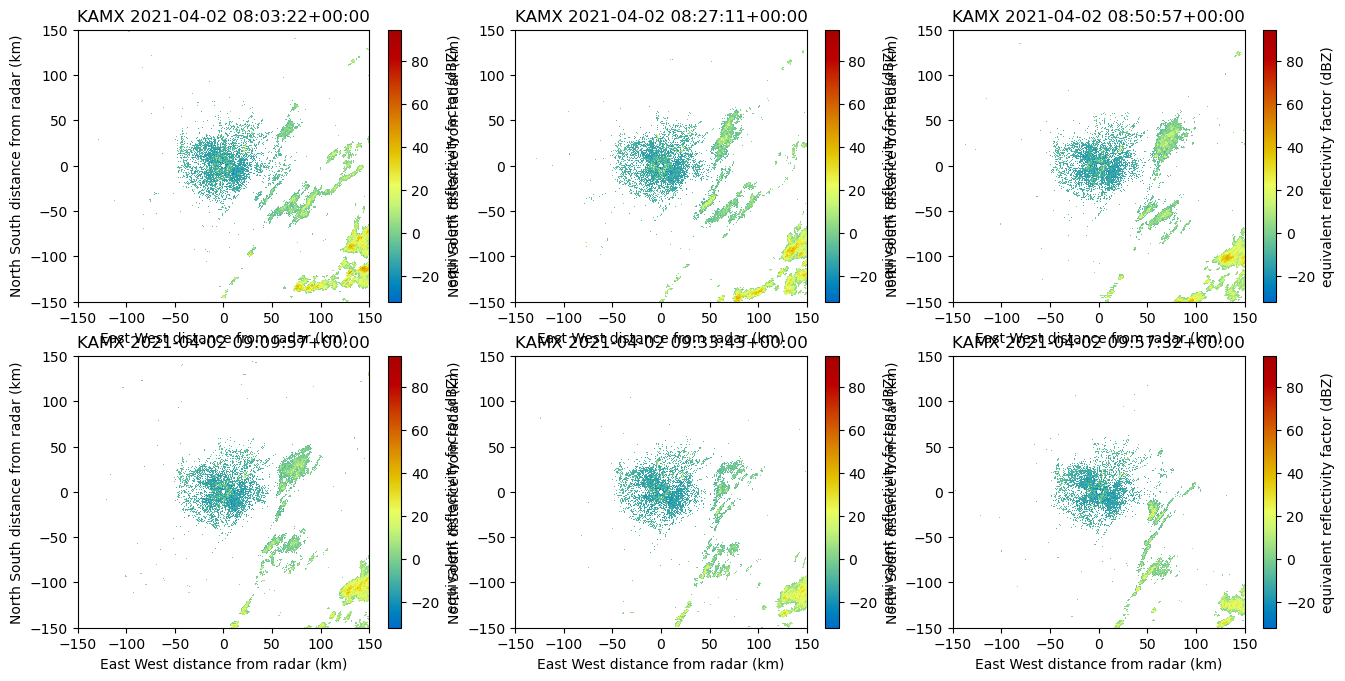

In [7]:
fig = plt.figure(figsize=(16,12))
for i,scan in enumerate(results.iter_success(),start=1):
    ax = fig.add_subplot(3,3,i)
    radar = scan.open_pyart()
    display = pyart.graph.RadarDisplay(radar)
    display.plot('reflectivity',0,ax=ax,title="{} {}".format(scan.radar_id,scan.scan_time))
    display.set_limits((-150, 150), (-150, 150), ax=ax)

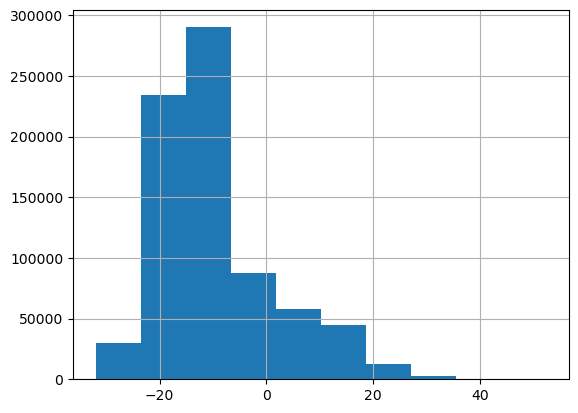

In [8]:
df=radar.fields["reflectivity"]["data"]
pd.Series(df.flatten()).hist()
plt.show()
#gatefilter = pyart.filters.GateFilter(radar)
#gatefilter.exclude_below('reflectivity', 0)

# Visualize velocity

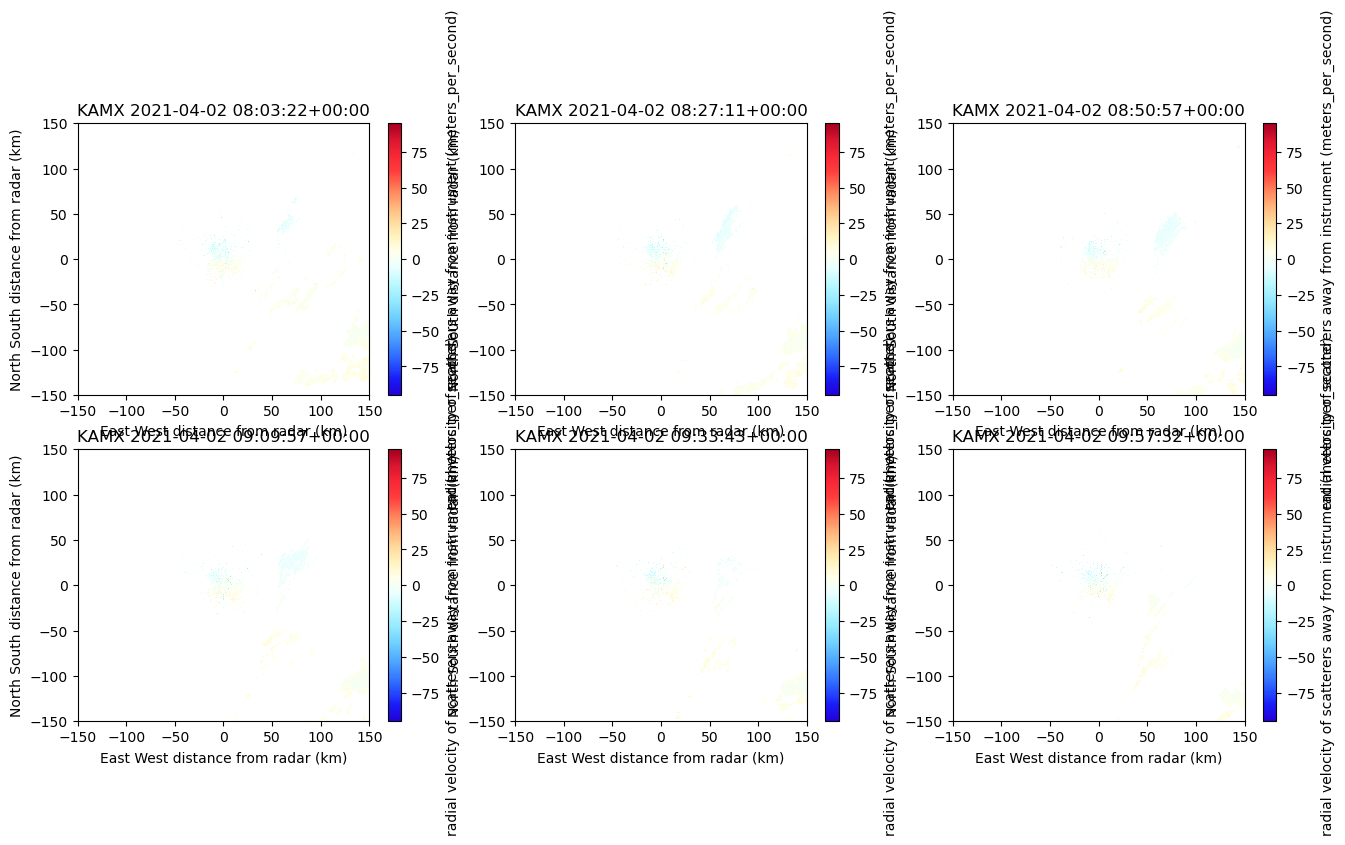

In [9]:
fig = plt.figure(figsize=(16,12))
for i,scan in enumerate(results.iter_success(),start=1):
    ax = fig.add_subplot(3,3,i)
    radar = scan.open_pyart()
    display = pyart.graph.RadarDisplay(radar)
    display.plot('velocity',1,ax=ax,title="{} {}".format(scan.radar_id,scan.scan_time))
    display.set_limits((-150, 150), (-150, 150), ax=ax)

# Filtering out weather

Based on coarse histograms found in https://esajournals.onlinelibrary.wiley.com/doi/10.1002/ecs2.1539, the range of reflectance tends to be about 0-30 (log scale) and differential phase greater than 90 degrees.

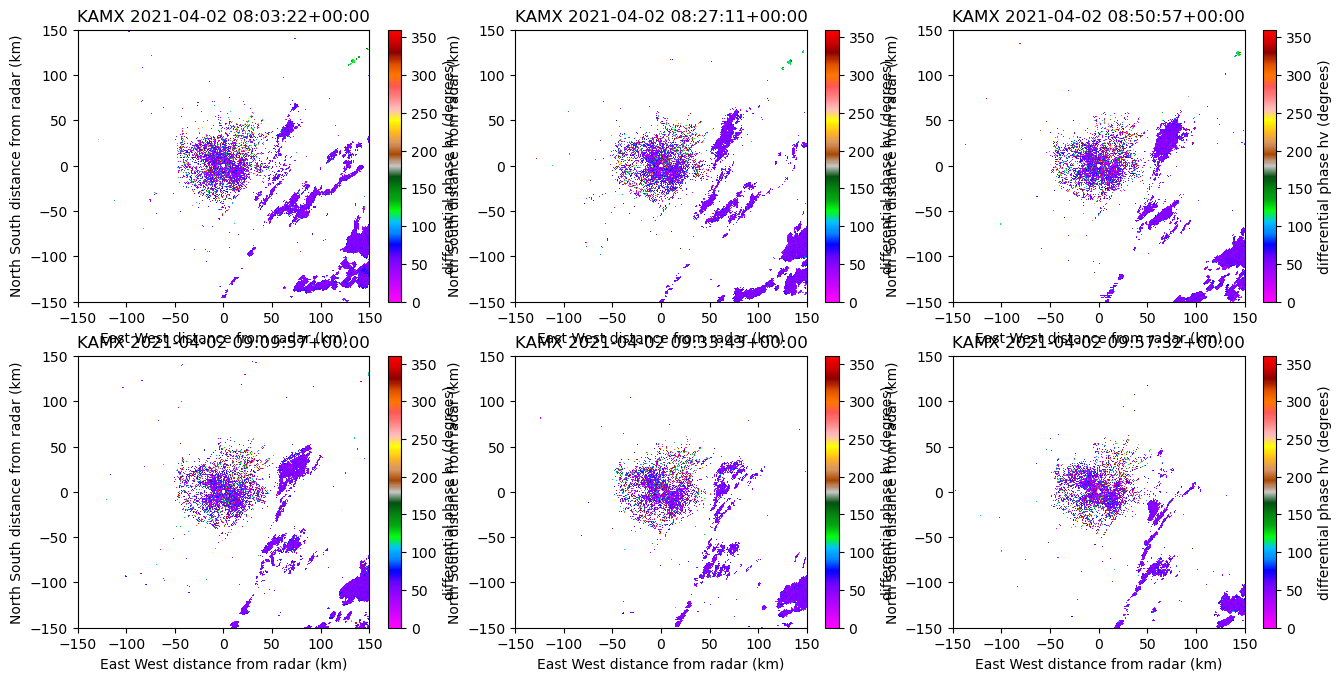

In [10]:
fig = plt.figure(figsize=(16,12))
for i,scan in enumerate(results.iter_success(),start=1):
    ax = fig.add_subplot(3,3,i)
    radar = scan.open_pyart()
    gate_filter = gatefilter = pyart.correct.GateFilter(radar)
    gate_filter.exclude_below("differential_phase",90)
    display = pyart.graph.RadarDisplay(radar)
    display.plot('differential_phase',0,ax=ax,title="{} {}".format(scan.radar_id,scan.scan_time))
    display.set_limits((-150, 150), (-150, 150), ax=ax)

# Geographic map

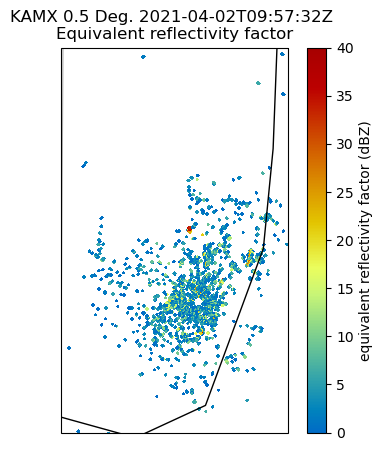

In [11]:
gate_filter = gatefilter = pyart.correct.GateFilter(radar)
gate_filter.exclude_below("reflectivity",0)
display = pyart.graph.RadarMapDisplay(radar)
projection = ccrs.LambertConformal(central_latitude=radar.latitude['data'][0],
                                   central_longitude=radar.longitude['data'][0])
fig = plt.figure(figsize=(5,5))
display.plot_ppi_map('reflectivity', 0, vmin=0, vmax=40,projection=projection,
                     fig=fig, lat_0=radar.latitude['data'][0],
                     lon_0=radar.longitude['data'][0], min_lat=25.1, max_lat=26.6, min_lon=-81.0, max_lon=-80.03, gatefilter=gate_filter)

In [12]:
radar.fields.keys()

dict_keys(['reflectivity', 'velocity', 'differential_reflectivity', 'cross_correlation_ratio', 'differential_phase', 'clutter_filter_power_removed', 'spectrum_width'])

# Create video of scans

In [178]:
# taken from https://github.com/zssherman/pyart_animation/blob/master/pyart_animation/pyart_animation.py
def animate(scan):
    plt.clf()
    try:
        radar = scan.open_pyart()
    except:
        return None
    gate_filter = pyart.correct.GateFilter(radar)
    gate_filter.exclude_below("reflectivity",0)
    display = pyart.graph.RadarMapDisplay(radar)
    projection = ccrs.LambertConformal(central_latitude=radar.latitude['data'][0],
                                       central_longitude=radar.longitude['data'][0])
    display.plot_ppi_map('reflectivity', 0, vmin=0, vmax=40,projection=projection,
                         lat_0=radar.latitude['data'][0], fig=fig,
                         lon_0=radar.longitude['data'][0], min_lat=25.1, max_lat=26.6, min_lon=-81.0, max_lon=-80.03, gatefilter=gate_filter)

In [14]:
scans = conn.get_avail_scans_in_range(start, end, radar_id)
len(scans)
results = conn.download(scans, templocation)
all_scans = [x for x in results.iter_success()]

Downloaded KAMX20210402_080322_V06
Downloaded KAMX20210402_082226_V06
Downloaded KAMX20210402_081739_V06
Downloaded KAMX20210402_080808_V06
Downloaded KAMX20210402_082711_V06
Downloaded KAMX20210402_081253_V06
Downloaded KAMX20210402_083642_V06
Downloaded KAMX20210402_084127_V06
Downloaded KAMX20210402_084612_V06
Downloaded KAMX20210402_085057_V06
Downloaded KAMX20210402_085542_V06
Downloaded KAMX20210402_083157_V06
Downloaded KAMX20210402_085542_V06_MDM
Downloaded KAMX20210402_090512_V06
Downloaded KAMX20210402_090957_V06
Downloaded KAMX20210402_090028_V06
Downloaded KAMX20210402_092413_V06
Downloaded KAMX20210402_091927_V06
Downloaded KAMX20210402_091442_V06
Downloaded KAMX20210402_093343_V06
Downloaded KAMX20210402_093829_V06
Downloaded KAMX20210402_094315_V06
Downloaded KAMX20210402_094801_V06
Downloaded KAMX20210402_092859_V06
Downloaded KAMX20210402_095246_V06
Downloaded KAMX20210402_095732_V06
Downloaded KAMX20210402_095732_V06_MDM
27 out of 27 files downloaded...0 errors


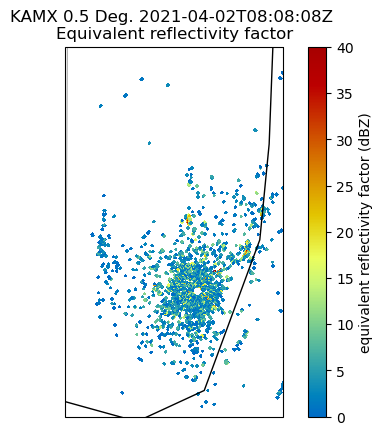

In [179]:
animate(all_scans[1])

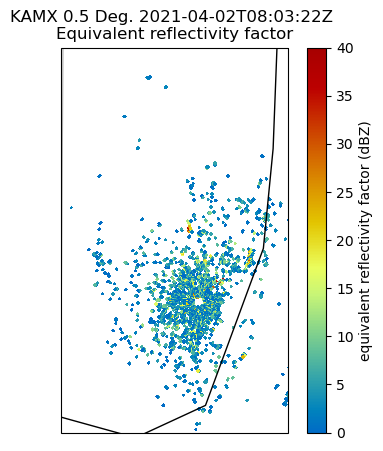

In [180]:
fig = plt.figure(figsize=(5, 5))
ani = animation.FuncAnimation(fig,animate, frames=all_scans[0:2],interval=1000, repeat_delay=1000)
ani.save("KAMX.gif")

In [114]:
radar.fields.keys()

dict_keys(['reflectivity', 'velocity', 'differential_reflectivity', 'cross_correlation_ratio', 'differential_phase', 'clutter_filter_power_removed', 'spectrum_width'])

# How do we find colony location within the cartesian grid?

In [17]:
radar.longitude

{'long_name': 'Longitude',
 'standard_name': 'Longitude',
 'units': 'degrees_east',
 'data': array([-80.41266632])}

In [18]:
radar.latitude

{'long_name': 'Latitude',
 'standard_name': 'Latitude',
 'units': 'degrees_north',
 'data': array([25.61108398])}

In [19]:
colonies = pd.read_csv("colonies.csv")

In [20]:
alley_north = colonies.loc[colonies.colony=="Alley North"]

It is probably not precise enough to subtract the colony location, but as a first pass lets try that using haversine distance.

In [21]:
radar_latlon = np.array([[radar.latitude["data"][0],radar.longitude["data"][0]]])
colony_latlon = np.array([alley_north[["latitude","longitude"]].values[0]])
sc_dist = cdist(radar_latlon, colony_latlon, lambda u, v: geodist(u, v).km)
sc_dist

array([[66.41624867]])

# Plot colonies over biological filters - KAMX

Historic colonies are shown in X

In [182]:
# taken from https://github.com/zssherman/pyart_animation/blob/master/pyart_animation/pyart_animation.py
def animate_colonies(scan):
    plt.clf()
    try:
        radar = scan.open_pyart()
    except:
        return None
    gate_filter = pyart.correct.GateFilter(radar)
    gate_filter.exclude_below("reflectivity",0)
    display = pyart.graph.RadarMapDisplay(radar)
    gate_filter.exclude_above("cross_correlation_ratio",0.75)
    projection = ccrs.LambertConformal(central_latitude=radar.latitude['data'][0],
                                       central_longitude=radar.longitude['data'][0])
    display.plot_ppi_map('reflectivity', 0, vmin=0, vmax=40,projection=projection,
                         lat_0=radar.latitude['data'][0], fig=fig,
                         lon_0=radar.longitude['data'][0], min_lat=25.1, max_lat=26.6, min_lon=-81.0, max_lon=-80.03, gatefilter=gate_filter)
    display.plot_point(colonies.longitude, colonies.latitude, markersize=3, symbol="x", color="black")

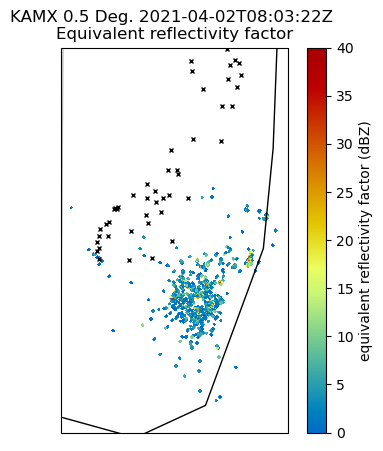

In [183]:
fig = plt.figure(figsize=(5, 5))
ani = animation.FuncAnimation(fig,animate_colonies, frames=all_scans[0:2],interval=1000, repeat_delay=1000)
ani.save("KAMX.gif")